In [32]:
import pyspark
from pyspark.sql import SparkSession
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [33]:
spark = SparkSession.builder.appName("Practise").getOrCreate()
spark

Read Dataset

In [34]:
df = spark.read.csv("ford.csv", header=True, inferSchema=True)
df.show(5)

+-------+----+-----+------------+-------+--------+---+----+----------+
|  model|year|price|transmission|mileage|fuelType|tax| mpg|engineSize|
+-------+----+-----+------------+-------+--------+---+----+----------+
| Fiesta|2017|12000|   Automatic|  15944|  Petrol|150|57.7|       1.0|
|  Focus|2018|14000|      Manual|   9083|  Petrol|150|57.7|       1.0|
|  Focus|2017|13000|      Manual|  12456|  Petrol|150|57.7|       1.0|
| Fiesta|2019|17500|      Manual|  10460|  Petrol|145|40.3|       1.5|
| Fiesta|2019|16500|   Automatic|   1482|  Petrol|145|48.7|       1.0|
+-------+----+-----+------------+-------+--------+---+----+----------+
only showing top 5 rows



EDA - Exploratory Data Analysis

In [35]:
df.describe().show()

23/06/22 06:18:36 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-------+------+------------------+------------------+------------+------------------+--------+------------------+------------------+-------------------+
|summary| model|              year|             price|transmission|           mileage|fuelType|               tax|               mpg|         engineSize|
+-------+------+------------------+------------------+------------+------------------+--------+------------------+------------------+-------------------+
|  count| 17966|             17966|             17966|       17966|             17966|   17966|             17966|             17966|              17966|
|   mean|  null|2016.8664699988867|12279.534843593454|        null|23362.608760992985|    null|113.32945563842814| 57.90697985082969| 1.3508070800400782|
| stddev|  null|2.0503359784876998| 4741.343657354183|        null| 19472.05434910513|    null|62.012456193801725|10.125695709164098|0.43236727240069733|
|    min| B-MAX|              1996|               495|   Automatic|         

In [36]:
#Get Data Type
df.printSchema()

root
 |-- model: string (nullable = true)
 |-- year: integer (nullable = true)
 |-- price: integer (nullable = true)
 |-- transmission: string (nullable = true)
 |-- mileage: integer (nullable = true)
 |-- fuelType: string (nullable = true)
 |-- tax: integer (nullable = true)
 |-- mpg: double (nullable = true)
 |-- engineSize: double (nullable = true)



In [37]:
#Get null values
from pyspark.sql.functions import isnan, when, count, col
df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+-----+----+-----+------------+-------+--------+---+---+----------+
|model|year|price|transmission|mileage|fuelType|tax|mpg|engineSize|
+-----+----+-----+------------+-------+--------+---+---+----------+
|    0|   0|    0|           0|      0|       0|  0|  0|         0|
+-----+----+-----+------------+-------+--------+---+---+----------+



In [38]:
df.columns

['model',
 'year',
 'price',
 'transmission',
 'mileage',
 'fuelType',
 'tax',
 'mpg',
 'engineSize']

Model creation

In [40]:
from pyspark.ml.feature import StringIndexer

indexer = StringIndexer(inputCols=['model','transmission','fuelType', 'mpg', 'engineSize'], 
                          outputCols=['modelIndexed','transmissionIndexed','fuelTypeIndexed', 'mpgIndexed', 'engineSizeIndexed'])

dfIndexed = indexer.fit(df).transform(df)
dfIndexed.show(5)

+-------+----+-----+------------+-------+--------+---+----+----------+------------+-------------------+---------------+----------+-----------------+
|  model|year|price|transmission|mileage|fuelType|tax| mpg|engineSize|modelIndexed|transmissionIndexed|fuelTypeIndexed|mpgIndexed|engineSizeIndexed|
+-------+----+-----+------------+-------+--------+---+----+----------+------------+-------------------+---------------+----------+-----------------+
| Fiesta|2017|12000|   Automatic|  15944|  Petrol|150|57.7|       1.0|         0.0|                1.0|            0.0|       4.0|              0.0|
|  Focus|2018|14000|      Manual|   9083|  Petrol|150|57.7|       1.0|         1.0|                0.0|            0.0|       4.0|              0.0|
|  Focus|2017|13000|      Manual|  12456|  Petrol|150|57.7|       1.0|         1.0|                0.0|            0.0|       4.0|              0.0|
| Fiesta|2019|17500|      Manual|  10460|  Petrol|145|40.3|       1.5|         0.0|                0.0|   

<Axes: >

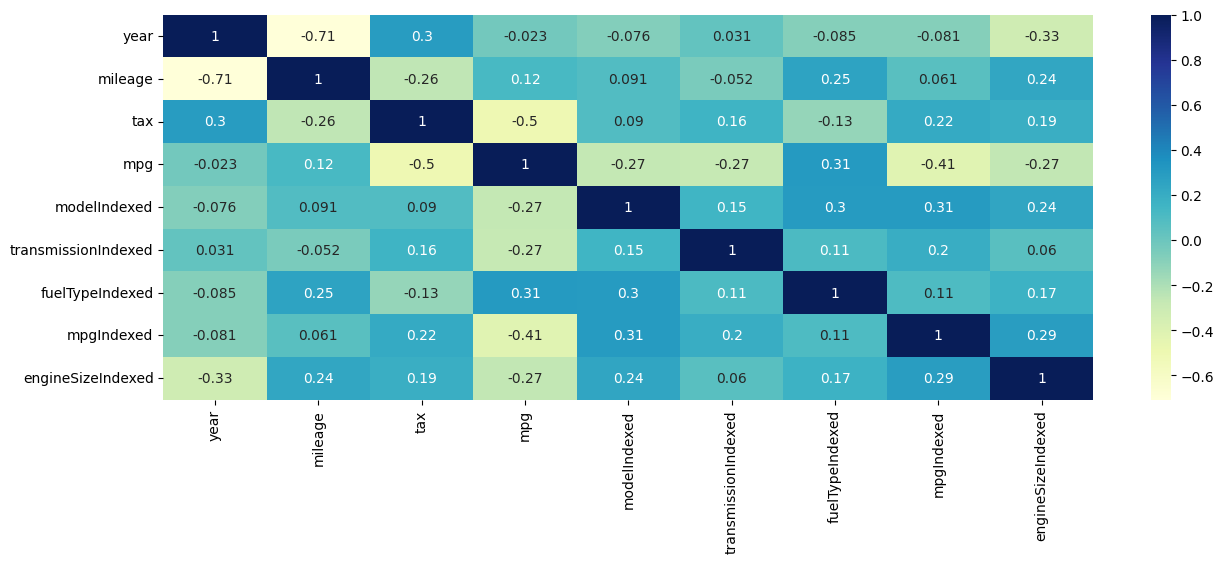

In [52]:
#Get correlation

#Configure size of the plot 
plt.figure(figsize=(15,5), dpi=100)
df2 = dfIndexed.select(['year','mileage','tax','mpg','modelIndexed','transmissionIndexed','fuelTypeIndexed', 'mpgIndexed', 'engineSizeIndexed'])
#df2.show(5)

#Convert to Pandas Df
pandasDf = df2.toPandas()
#pandasDf.head() # view dataset after converting to pd data frame 

sns.heatmap(pandasDf.corr(), cmap="YlGnBu", annot=True)

In [ ]:
from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(inputCols=['year','mileage','tax','mpg','modelIndexed','transmissionIndexed','fuelTypeIndexed', 'mpgIndexed', 'engineSizeIndexed'],
                            outputCol='IndependentVariable')
output = assembler.transform(dfIndexed)
output.show(5)

from pyspark.ml.regression import LinearRegression
selectedFeatures = output.select(["IndependentVariable", "price"])
#split dataset 
trainData, testData = selectedFeatures.randomSplit([0.8,0.2])
regModel = LinearRegression(
    featuresCol="IndependentVariable", labelCol="price"
)
regressor = regModel.fit(trainData)

+-------+----+-----+------------+-------+--------+---+----+----------+------------+-------------------+---------------+----------+-----------------+--------------------+
|  model|year|price|transmission|mileage|fuelType|tax| mpg|engineSize|modelIndexed|transmissionIndexed|fuelTypeIndexed|mpgIndexed|engineSizeIndexed| IndependentVariable|
+-------+----+-----+------------+-------+--------+---+----+----------+------------+-------------------+---------------+----------+-----------------+--------------------+
| Fiesta|2017|12000|   Automatic|  15944|  Petrol|150|57.7|       1.0|         0.0|                1.0|            0.0|       4.0|              0.0|[2017.0,15944.0,1...|
|  Focus|2018|14000|      Manual|   9083|  Petrol|150|57.7|       1.0|         1.0|                0.0|            0.0|       4.0|              0.0|[2018.0,9083.0,15...|
|  Focus|2017|13000|      Manual|  12456|  Petrol|150|57.7|       1.0|         1.0|                0.0|            0.0|       4.0|              0.0|[2

23/06/22 05:39:46 WARN Instrumentation: [7bd94e68] regParam is zero, which might cause numerical instability and overfitting.


In [ ]:
#preview
output.select(["IndependentVariable"]).show(5)

+--------------------+
| IndependentVariable|
+--------------------+
|[2017.0,15944.0,1...|
|[2018.0,9083.0,15...|
|[2017.0,12456.0,1...|
|[2019.0,10460.0,1...|
|[2019.0,1482.0,14...|
+--------------------+
only showing top 5 rows



In [ ]:
regressor.coefficients

DenseVector([1054.355, -0.06, 5.3363, -156.8057, 65.4079, 275.805, 4103.9851, 52.5717, -225.594])

In [ ]:
regressor.intercept

-2106062.8457068433

In [ ]:
y_pred = regressor.evaluate(testData)

In [ ]:
y_pred.predictions.show(5)

+--------------------+-----+------------------+
| IndependentVariable|price|        prediction|
+--------------------+-----+------------------+
|(9,[0,1,2,3],[201...|10995|11042.667344268411|
|(9,[0,1,2,3],[201...| 9998|10768.757661832497|
|(9,[0,1,2,3],[201...|14932|10701.045779744629|
|(9,[0,1,2,3],[201...|11495| 10671.11265231762|
|(9,[0,1,2,3],[201...| 9267| 10650.89729371434|
+--------------------+-----+------------------+
only showing top 5 rows



Checking model performance 

In [ ]:
# Get the R^2 
r2_test= y_pred.r2
print(f"R2 score on test set: {round(r2_test*100,2)}")

R2 score on test set: 72.53


## Conclusion
<p>The model performance is above average but isn't very great. The model can definitely improve by preprocessing the data further:</p>
<ul>
<li>Removing outliers</li>
<li>Feature selection through PCA</li>
<li>Standardizing the feature scale</li>
<li>Hyperparameter tuning </li>
</ul>